In [1]:
#!pip3 install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
#!pip3 install pylatexenc

In [177]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, execute, Aer
from qiskit.visualization import *
from qiskit.aqua.components.oracles import TruthTableOracle
from qiskit.extensions.unitary import unitary
from qiskit_textbook.tools import array_to_latex
import matplotlib.pyplot as plt

In [108]:
def exec_circuit(circuit, backend=Aer.get_backend('qasm_simulator')):
    res = execute(circuit, backend).result()
    return res, res.get_counts()

def init_circuit(circuit, init_state=None, target_qubits=None):
    '''
    Initialize the circuit with the init_state applied to the
    target_quibts
    '''
    if init_state != None and target_qubits != None:
        circuit.initialize(init_state, target_qubits)

def run_on_inputs(fn_create_circuit, n, input_qubits=None):
    '''
    :param n: the number of qubits
    :param fn_create_circuit: a function to create a circuit
    :return: the run of the circuits on all possible inputs
    '''
    N = pow(2, n)
    if input_qubits == None:
        input_qubits = list(range(0, n))
    assert n == len(input_qubits), "The number of qubits and its labels need to match"
    f, ax = plt.subplots(N, figsize=(10,15))
    f.subplots_adjust(wspace=0.9)
    f.tight_layout(pad=3)
    for i in range(0,N):
        s = [0] * N
        s[i] = 1
        circ = fn_create_circuit(s, input_qubits)
        res, cts = exec_circuit(circ)
        ax[i].set_title(f'Case {s}')
        plot_histogram(cts, ax=ax[i])

## A simple circuit
The below circuit is a sample circuit to get acquianted with qiskit's syntax and semantics of building
a quantum circuit

It also demonstrastes a very interesting fact. Control Qbits can be **altered** by the mered act of
being a control qbits.

For example in the circuit below, the top qbuit is going through twice, which at first glance would
restore it to its initial state, but becuase of its interaction with the 2nd qbit via the CNOT gate, the
state of the 1st qbit also changes.

In [203]:
def simple_circ(init_state=None, qubits=None):
    circ = QuantumCircuit(2,2)
    circ.reset(range(2))
    circ.x(1)
    circ.h(range(2))
    circ.cx(0,1)
    circ.h(range(2))
    circ.measure(0, 0)
    circ.measure(1, 1)
    return circ

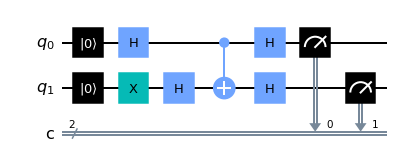

In [204]:
circ = simple_circ()
circ.draw()

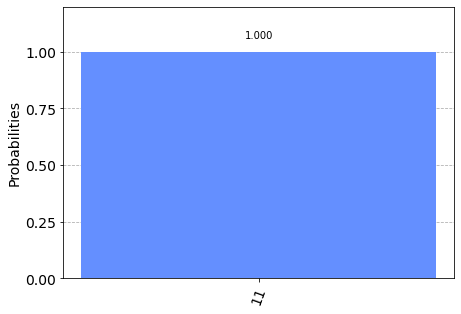

In [205]:
res, cts = exec_circuit(circ)
plot_histogram(cts)

The result is the state $ |11\rangle $. Which means the LSQ went from 0 -> 1, even though a only HH acted
on it.

### Simple circuit to calculate sum mod 2
One of the simplest circuits I remember working on when I was learning about classical CPUs.
was 1-bit adder.
The below circuit is a 1-qbit adder, without carry.

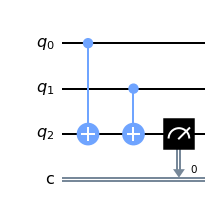

In [4]:
def create_adder(init_state=None, qbits=None):
    n_q = 3
    n_m = 1
    circ = QuantumCircuit(n_q,n_m)
    init_circuit(circ, init_state, qbits)
    circ.cnot(0,2)
    circ.cnot(1,2)
    circ.measure(2,0)
    return circ
circ = create_adder()
circ.draw()

The circuit above also allows me to execercsie the function that runs the circuit on all possible
inputs.

That is 00,01,10,11. The circuit calculates $$ (x_1 + x_2) mod $$ 2.
Bear in mind that the inputs for this function  is the tensor of $$q_0$$ and $$q_1$$. So 00 = $$\pmatrix{1\\0\\0\\0} $$

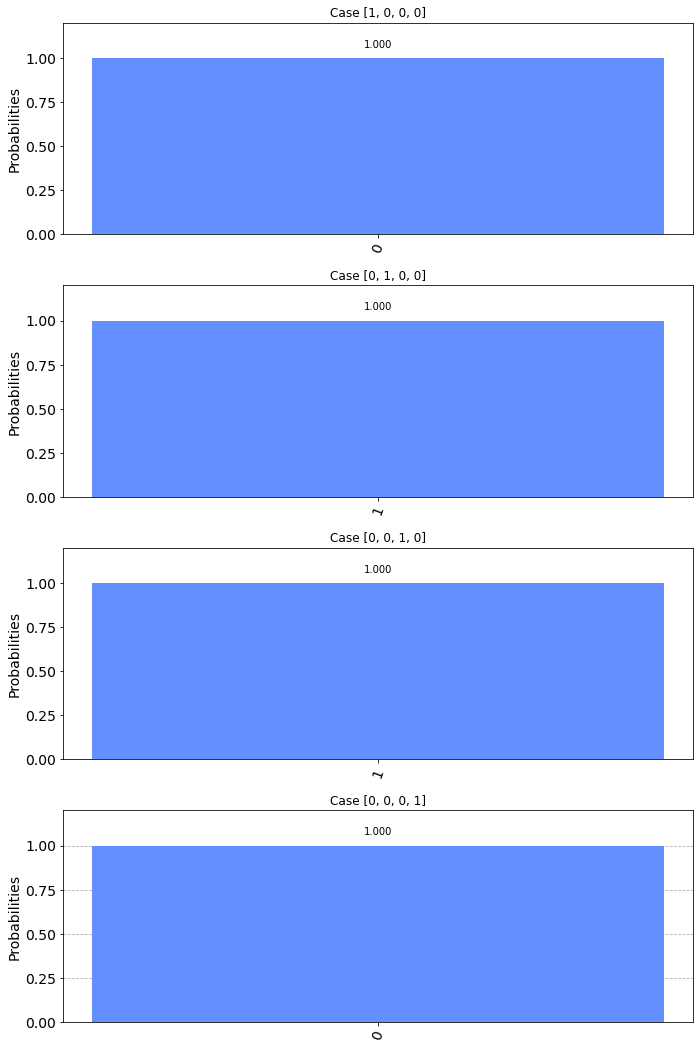

In [5]:
run_on_inputs(create_adder, 2)

## Indirect measurement circuit
The below circuit measures the top qubit, and with that also inspects the value of the bottom qubit.
The final state of this circuit is of the form
$$ a|00> + b|00> $$

Where $ a|0> + b|0> $ is the bottom qubit. Thus measuring the top qubit is equivalent at measuring the
bottom qubit.

This type of circuits in commonly found in quantum correcting circuits.

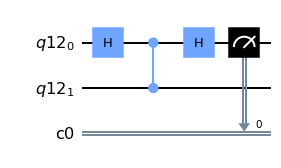

In [6]:
def create_indirect_measure(init_state=None, target_init_qubits=None):
    n = 2
    reg = QuantumRegister(n)
    creg = ClassicalRegister(1)
    circ = QuantumCircuit(reg, creg)
    init_circuit(circ, init_state, target_init_qubits)
    circ.h(0)
    circ.cz(0,1)
    circ.h(0)
    circ.measure(0,0)
    return circ
circ = create_indirect_measure()
circ.draw()

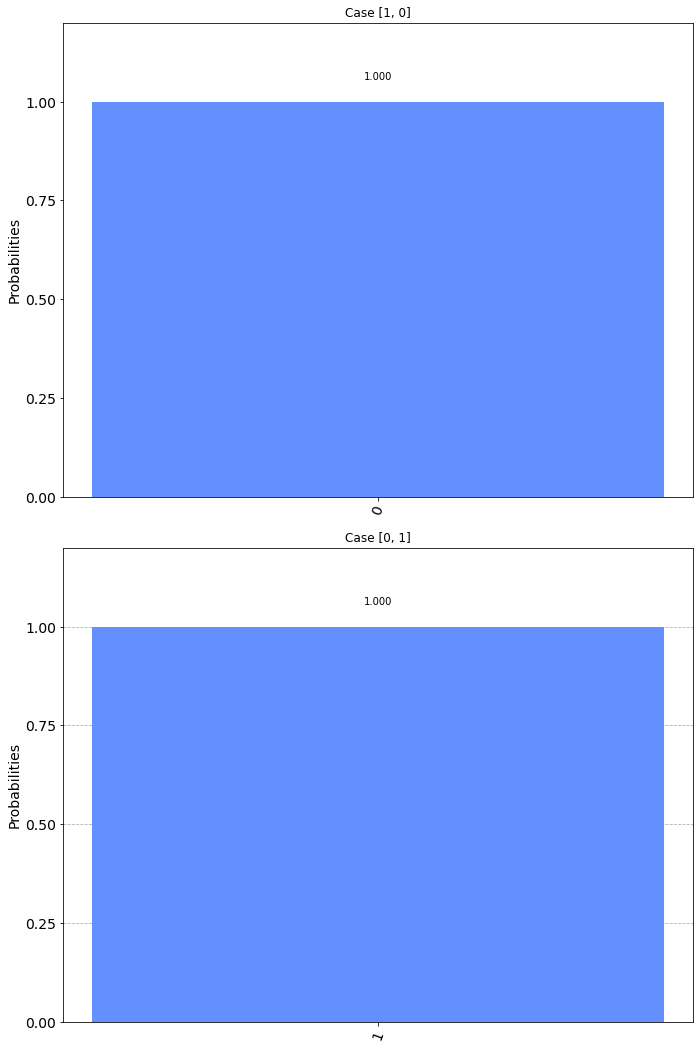

In [7]:
run_on_inputs(create_indirect_measure, 1)

## Quantum kickback to find a secret string
Let us examine a different circuit now which encodes a phase quickback to find an answer.
Let us suppose we have an oracle O that given an index i returns the value of bit at the i-th location for
a string x.

By querying such oracle with all the bits  of the string we can learn the whole string x

With the circuit below, we can recover a secret string x utilizing said oracle.
I will start by encoding the oracle into a quantum circuit and to start my exploration I'll start
with a fix string x = "101"

In [220]:
def oracle_for_fixed_string():
    '''
    This circuit implements the mod 2 sum of x_i * s_i, for a fixed string s = "101"
    :param s:
    :return:
    '''
    s = "101"
    n = len(s) + 1
    circ = QuantumCircuit(n)
    circ.cx(0,3)
    circ.cx(2,3)
    return circ

The above circuit implements a search on the mod 2 sum of $x_i * s_i$ or $x_0*s_0 \oplus x_1*s_1 \oplus ...$
when $x = 101$

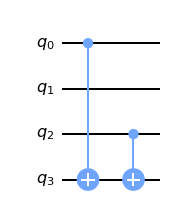

In [221]:
sc = oracle_for_fixed_string()
sc.draw()

It seems like function to produce a circuit that implements the parity check of a string is simply
the CNOTs of all the on-bits

In [234]:
def oracle_for_string(s):
    n = len(s) + 1 ## +1 for the ancilla where we read the answer from
    circ = QuantumCircuit(n)
    for i, b in enumerate(reversed(s)):
        if b == "1":
            circ.cx(i, n - 1)
    return circ

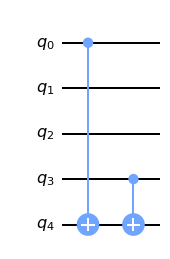

In [238]:
sc = oracle_for_string("1001")
sc.draw()

In [251]:
n = 4
def bit_search(s, init_state=None, target_init_qubits=None):
    reg = QuantumRegister(n,"x")
    creg = ClassicalRegister(n - 1)
    circ=QuantumCircuit(reg, creg)
    init_circuit(circ, init_state, target_init_qubits)
    circ.reset(n - 1)
    circ.x(n - 1)
    circ.h(range(n))
    orc = oracle_for_string(s).to_gate(label="search circ")
    circ.append(orc, range(n))
    circ.h(range(n))
    for i in range(n -1):
        circ.measure(i, i)
    return circ

Let's draw the circuit to visualize it first

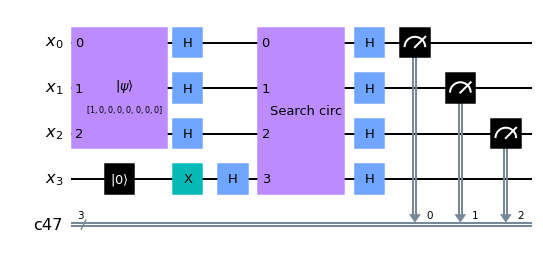

In [252]:
circ = bit_search("101", [1, 0, 0, 0, 0, 0, 0, 0], [0,1,2])
circ.draw()

Running the circuit and measuring the top register, we will recover the initial string x

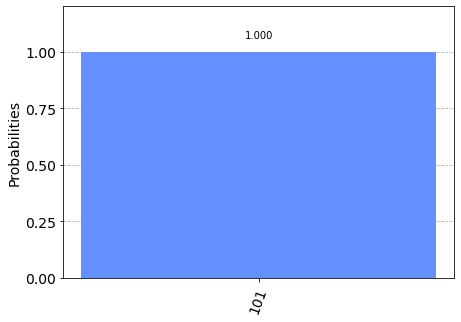

In [245]:
res, cts = exec_circuit(circ)
plot_histogram(cts)

That's great as we can see for reading the inputs the string "101" is read with 100% probability. Which
is exactly the same as the input string x we used in the search oracle.

Now let's try it on other strings

- On input string 001, we should recover "001" with 100% probability

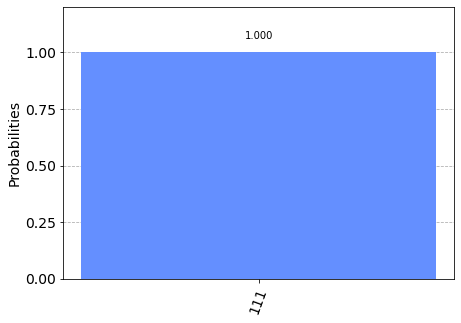

In [248]:
circ = bit_search("001", [1, 0, 0, 0, 0, 0, 0, 0], [0,1,2])
res, cts = exec_circuit(circ)
plot_histogram(cts)

- The same with input string 111

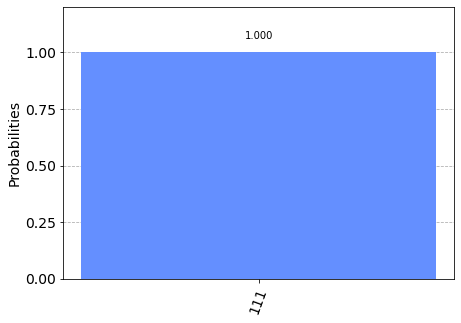

In [250]:
circ = bit_search("111", [1, 0, 0, 0, 0, 0, 0, 0], [0,1,2])
res, cts = exec_circuit(circ)
plot_histogram(cts)

Last thing to not is that "search circ" is different in each of the input strings

